# Застосування швидкого перетворення Фур'є при обробці звуку з метою генерації ознак, які далі можуть використовуватись для кластеризації чи класифікації.
## Визначаємо функції
### Функція завантаження звуку

In [53]:
import numpy as np
from collections.abc import Iterable
import tempfile
from pathlib import Path
import io
import requests
import tempfile
import librosa
from sympy.stats.sampling.sample_scipy import scipy

def load_audio_to_dataset(audio_name: str) -> tuple[np.ndarray, int | float]:
    timeout=(5, 60)
    url = f"https://github.com/karolpiczak/ESC-50/blob/master/audio/{audio_name}?raw=true"
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; DataFetch/1.0)",
        "Accept": "application/octet-stream",
    }
    resp = requests.get(url, stream=True, timeout=timeout, headers=headers)
    if not resp.ok:
        raise RuntimeError(f"Download failed: HTTP {resp.status_code} - {resp.reason}")

    buf = io.BytesIO()

    for chunk in resp.iter_content(chunk_size=1024 * 64):
        buf.write(chunk)

    buf.seek(0)

    tmp_file = Path(tempfile.gettempdir()) / audio_name

    with open(tmp_file, "wb") as f:
        f.write(buf.read())

    result = librosa.load(tmp_file, sr=None)

    tmp_file.unlink()

    return result

### Функція створення спектрограми

In [54]:
from matplotlib import pyplot as plt


def spectrogram(samples, sample_rate, stride_ms = 10.0,
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples,
                                          shape = nshape, strides = nstrides)

    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]

    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2

    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale

    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    # Compute spectrogram feature
    # ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:, :] + eps)
    return specgram

def spect_show(spect_matrix):

    plt.imshow(spect_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Візуалізація спектральної матриці')
    plt.xlabel('Номер фрейму')
    plt.ylabel('Частота')
    plt.show()


### Функція завантаження категорій звуків

In [55]:
import csv


def load_categories(*categories) -> dict[str, list[np.ndarray]]:
    url = "https://github.com/karolpiczak/ESC-50/blob/master/meta/esc50.csv?raw=true"
    timeout=(5, 60)
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; DataFetch/1.0)",
        "Accept": "application/octet-stream",
    }
    resp = requests.get(url, stream=True, timeout=timeout, headers=headers)
    if not resp.ok:
        raise RuntimeError(f"Download failed: HTTP {resp.status_code} - {resp.reason}")
    samples = {}
    for category in categories:
        reader = csv.DictReader(io.StringIO(resp.text))
        samples[category] = [load_audio_to_dataset(fn["filename"]) for fn in reader if fn["category"].strip() == category.strip()]

    return samples

### Функція стиснення аудіо

In [56]:
def pooling_audio(mat,ksize,method='max',pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling,
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize

    _ceil=lambda x,y: int(np.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=np.full(size,np.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=np.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=np.nanmean(mat_pad.reshape(new_shape),axis=(1,3))

    return result


### Функція перетворення спектру звуків у спектр спектрограм

In [57]:
def convert_to_spectrogramm(audios: dict[str, list[np.ndarray]]) -> dict[str, list[np.ndarray]]:
    return {k: list(map(lambda v: spectrogram(*v), v)) for k, v in audios.items()}

### Функція перетворення спектру спектрограм у спектр стиснених спектрограм

In [58]:
def convert_to_pools(spectros: dict[str, list[np.ndarray]]) -> dict[str, list[np.ndarray]]:
    return {k: list(map(lambda v: pooling_audio(v, (20, 20)), v)) for k, v in spectros.items()}

### Функція перетворення матриці стиснених спектрограм  у одновимірний простів

In [59]:
def flatten_pooled_audio(pooled_spectros: dict[str, list[np.ndarray]]) -> np.ndarray:
    """
    Повертає np.ndarray форми (N, H, W), де N — кількість спектрограм.
    Пропускає масиви з невідповідною розмірністю (не 2D/3D).
    Якщо 3D (B, H, W) — розбиває по осі B.
    Якщо 2D (H, W) — додає ось прикладів.
    """
    collected = []

    def collect_arrays(node):
        if isinstance(node, np.ndarray):
            if node.ndim == 3:
                # (B, H, W) -> розділити по B
                for i in range(node.shape[0]):
                    collected.append(node[i])
            elif node.ndim == 2:
                # (H, W) -> додати як один приклад
                collected.append(node)
            else:
                # Ігноруємо 1D чи інші форми, бо це не спектрограми
                pass
        elif isinstance(node, dict):
            for v in node.values():
                collect_arrays(v)
        elif isinstance(node, Iterable) and not isinstance(node, (str, bytes)):
            for v in node:
                collect_arrays(v)
        else:
            pass

    collect_arrays(pooled_spectros)

    if not collected:
        raise ValueError("Не знайдено жодної 2D/3D спектрограми у pooled_spectros")

    # Перевірка сумісності H, W; якщо різні — можна або ресемплити, або кидати помилку
    H, W = collected[0].shape
    for i, a in enumerate(collected):
        if a.shape != (H, W):
            raise ValueError(f"Несумісні розміри спектрограм: очікувалось {(H, W)}, отримано {a.shape} на індексі {i}")

    # Сформувати (N, H, W)
    return np.stack(collected, axis=0)

## Завантаження спектру звуків

In [60]:
soundarray = load_categories("dog", "chirping_birds")
y, sr = soundarray["dog"][0]
print(f"Довжина аудіо: {len(y)} зразків")
print(f"Частота дискретизації: {sr} Гц")

Довжина аудіо: 220500 зразків
Частота дискретизації: 44100 Гц


In [61]:
y1, sr1 = soundarray["chirping_birds"][0]
print(f"Довжина аудіо: {len(y1)} зразків")
print(f"Частота дискретизації: {sr1} Гц")

Довжина аудіо: 220500 зразків
Частота дискретизації: 44100 Гц


## Створення спектрограми нестисненого звуку

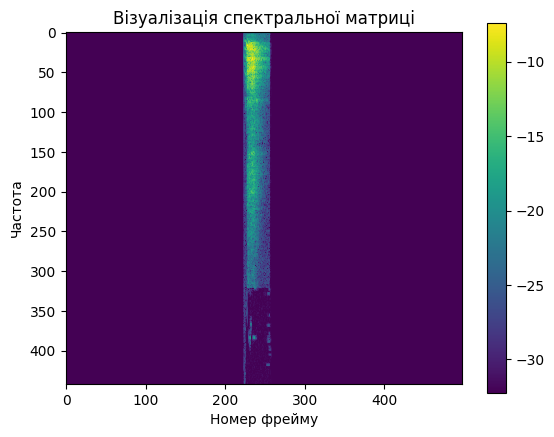

In [62]:
spect_matrix_db = convert_to_spectrogramm(soundarray)
spect_show(spect_matrix_db["dog"][0])

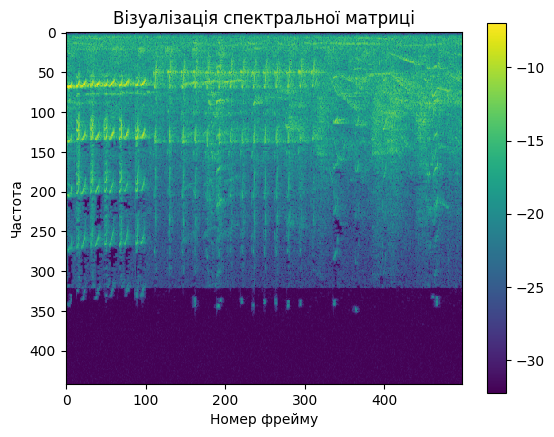

In [63]:
spect_show(spect_matrix_db["chirping_birds"][0])

## Стиснення звуків

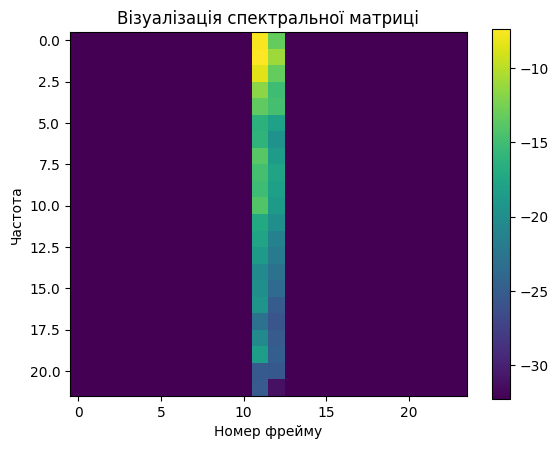

In [64]:
pooled_result = convert_to_pools(spect_matrix_db)

spect_show(pooled_result["dog"][0])

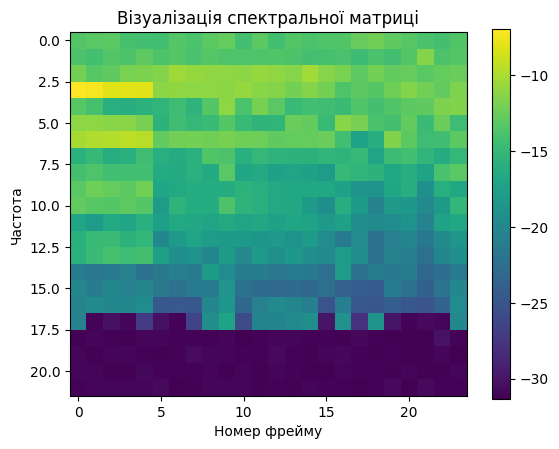

In [65]:
spect_show(pooled_result["chirping_birds"][0])

## Створення кругової кластеризації та її візуалізація по кластерах, що еквівалентні категоріям завантажених звуків

In [66]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

def get_circles(flattened_spectros: np.ndarray):
    """
    Приймає масив спектрограм форми:
      - (n_samples, n_features) АБО
      - (n_samples, f, t) АБО
      - (n_samples, c, f, t)
    Повертає мітки кластерів (n_samples,).
    """
    X = np.asarray(flattened_spectros)

    # Приведення типу
    if not np.issubdtype(X.dtype, np.floating):
        X = X.astype(np.float64, copy=False)

    # Узгодження розмірності до 2D (n_samples, n_features)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    elif X.ndim == 2:
        pass  # вже ок
    elif X.ndim == 3:
        # (n, f, t) -> (n, f*t)
        n, f, t = X.shape
        X = X.reshape(n, f * t)
    elif X.ndim == 4:
        # (n, c, f, t) -> усереднити по каналу -> (n, f*t)
        n, c, f, t = X.shape
        X = X.mean(axis=1).reshape(n, f * t)
    else:
        raise ValueError(f"Непідтримувана розмірність масиву: {X.ndim}D")

    # Обробка NaN/Inf
    if not np.isfinite(X).all():
        # варіант: заміна на 0 або медіану по ознаці
        col_median = np.nanmedian(np.where(np.isfinite(X), X, np.nan), axis=0)
        # де Inf -> NaN
        X = np.where(np.isfinite(X), X, np.nan)
        # заповнення NaN медіанами
        inds = np.where(~np.isfinite(X))
        X[inds] = np.take(col_median, inds[1])

    # Масштабування (часто допомагає для спектральної кластеризації)
    X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

    sc = SpectralClustering(
        n_clusters=2,
        affinity='nearest_neighbors',
        n_neighbors=10,
        assign_labels='kmeans',
        random_state=42
    )
    return sc.fit_predict(X)

In [67]:
def draw_circles(flattened_spectros: np.ndarray, circles, labels: list):
    # Візуалізація кластерів з легендою
    plt.figure(figsize=(7, 5))
    palette = np.array(['crimson', 'royalblue'])
    mask0 = circles == 0
    mask1 = circles == 1
    plt.scatter(flattened_spectros[mask0, 0], flattened_spectros[mask0, 1], c=palette[0], s=25, edgecolors='k', linewidths=0.4, alpha=0.9, label=labels[0])
    plt.scatter(flattened_spectros[mask1, 0], flattened_spectros[mask1, 1], c=palette[1], s=25, edgecolors='k', linewidths=0.4, alpha=0.9, label=labels[1])
    plt.title("Spectral Circles")
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', frameon=True)
    plt.tight_layout()
    plt.show()

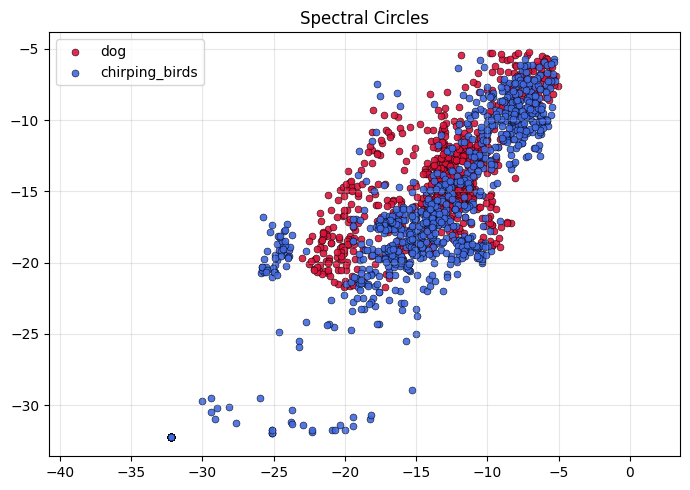

In [68]:
flattened_spectros = flatten_pooled_audio(pooled_result)
circles = get_circles(flattened_spectros)
draw_circles(flattened_spectros, circles, labels=["dog", "chirping_birds"])

## Висновки
### Аналіз отриманих кластерів
Як бачимо з розподілу кластерів, кластери спектрів звуків собак та птахів перетинаються. Як бачимо із спектральних візуалізацій одного зразку звуку собаки та птаха, перший зразок має спектри, сконцентровані ближче до центру, тоді, як пташиний розподілений на всю ширину. Це дуже гарно перетинається і з тим розподілом кластерів, який ми бачимо в останній візуалізації.

### Значення застосування перетворення Фур'є для вилучення ознак даних
Як бачимо, за допомогою перетворення Фурʼє ми можемо стиснути аудіо дані та створити спектрограми, котрі дозволили нам отримати ознаки величин спектрів, за допомогою яких ми змогли проаналізувати особливості звуків різних джерел звуку.
власне на основі цього ми і змогли провести нашу кластеризацію звуків різних джерел звуку.